# TODO fase 1
 - augmentation of training data by mixing stock prices
 - use hooks to verify that the weights has a sufficeint variance
 - calculate candlestick using pca
 - calculate predictions for a stock fx apple
 - statistics for the predictions: distribution of errors, percentage prediction with the right direction:  close>open, open<close
 - visualize ohlc as bands and on stock curve
 - split in train, test so that test data are taken from time periodens after the training data and possibly from stocks that have not been used for training 

 - tjek quantile objective function
 - objectiv function that weigh open and closing prices higher

 - add day of week to training data
                                                                                                                 
                                                                                                                 
# TODO fase 2
 - language modelling

# DONE 
 - speed up training: improve the pandas part by 30 to 60 times


In [ ]:
#default_exp finance.train

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from lib.data.lists import *
from lib.finance.data import *
from pathlib import Path

import pandas as pd
import numpy as np

#import matplotlib.pyplot as plt

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

# Load data


In [ ]:
df_prices = loadShareprices()

dataPath:/Users/kasparlund/simfin_data exists:True
Dataset "us-shareprices-daily" on disk (28 days old).
- Loading from disk ... Done!


In [ ]:
df_prices, stocks, validStocks, inValidStocks = procesSharePrices(df_prices)

number of stocks:         2615
number of valid stocks:   1626
number of invalid stocks: 989
smallest pricelines pr stock: Ticker
NLN      1
WMG      2
SSI     17
GAMZ    18
PCP     24
dtype: int64
longest pricelines pr stock:  Ticker
HTH    3379
HT     3379
HSY    3379
HST    3379
KBR    3379
dtype: int64


In [ ]:
#statistics on the mature stocks
stats = df_prices.loc[validStocks,[PREV_CLOSE,OPEN,HIGH,LOW,CLOSE]].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])        
stats

,previous_close,Open,High,Low,Close
count,4.354298e+06,4.354298e+06,4.354298e+06,4.354298e+06,4.354298e+06
mean,3.469855e+00,1.027393e-04,1.480531e-02,-1.525057e-02,2.008895e-04
std,9.837691e-01,1.391626e-02,2.161822e-02,2.295876e-02,2.620453e-02
min,-3.912023e+00,-4.829644e-01,-4.327939e-01,-4.995624e-01,-4.867261e-01
0.02%,-3.912023e+00,-1.978955e-01,-1.431591e-01,-3.280761e-01,-2.681582e-01
25%,2.888147e+00,-3.777153e-03,3.724399e-03,-2.094438e-02,-9.926187e-03
50%,3.492560e+00,0.000000e+00,1.023463e-02,-1.012382e-02,2.614819e-04
75%,4.052307e+00,4.359616e-03,2.029475e-02,-3.302827e-03,1.068488e-02
99.98%,1.239616e+01,1.648063e-01,2.801563e-01,1.179797e-01,2.334339e-01
max,1.275121e+01,4.894546e-01,4.985555e-01,4.795731e-01,4.818492e-01


In [ ]:
#type(stats.loc["mean",CLOSE])
#print(f"{df_prices[CLOSE]-stats.loc['mean',CLOSE]}")
#print( f"mean=0 percentage =>0: {df_prices[CLOSE]-stats.loc["mean",CLOSE]}")

In [ ]:
%%time
df_valid =df_prices.loc[validStocks]
print( f"percentage =>0: {df_valid[CLOSE].ge(0).sum()/len(df_valid)*100}")
print( f"percentage ==0: {df_valid[CLOSE].eq(0).sum()/len(df_valid)*100}")
print( f"percentage  <0: {df_valid[CLOSE].lt(0).sum()/len(df_valid)*100}")

print( f"mean=0 percentage =>0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).ge(0).sum()/len(df_valid)*100}")
print( f"mean=0 percentage ==0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).eq(0).sum()/len(df_valid)*100}")
print( f"mean=0 percentage  <0: {(df_valid[CLOSE]-stats.loc['mean',CLOSE]).lt(0).sum()/len(df_valid)*100}")
del df_valid

percentage =>0: 52.569759809732815
percentage ==0: 2.273041486825201
percentage  <0: 47.430240190267185
mean=0 percentage =>0: 50.13044582616991
mean=0 percentage ==0: 0.0
mean=0 percentage  <0: 49.86955417383009
CPU times: user 338 ms, sys: 107 ms, total: 445 ms
Wall time: 443 ms


In [ ]:
import torch
import torch.nn as nn
import random
class OHLCDatasetClose(OHLCDataset):
    #x, y significes input vs output
    def __init__(self, df_prices, stocks, column_names, seq_length): 
        super().__init__(df_prices, stocks, column_names, seq_length)
        
    def __getitem__(self, index):
        #pt: price target
        #pi: price input
        ix = self.idx_seq[index,:]        
        pi = torch.tensor( self.np_prices[ix[1]:ix[0]] )
        pt = torch.tensor( self.np_prices[ix[0]:ix[0]+1] )
        if self.mixing_ratio>0:
            #mix with another sequence
            ix = self.idx_seq[random.randint(0, len(self)-1),:]
            r  = random.uniform(0, self.mixing_ratio )
            r1 = 1-r
            pi = pi*r1 + r*torch.tensor( self.np_prices[ix[1]:ix[0]] )
            pt = pt*r1 + r*torch.tensor( self.np_prices[ix[0]:ix[0]+1] )
        return pi, pt #, index


In [ ]:
%%time 

from lib.learner.learner import*
from lib.learner.optimizers import*
from lib.model.model import*
from lib.model.modelmanager import*
import torch.nn as nn

seq_length = 360
training_columns = [CLOSE,OPEN]
#mean is so close to zero so we only devide by std
stats = df_prices.loc[validStocks].describe(percentiles=[0.0002, 0.01, 0.25, 0.75, 0.99, 0.9998])
df_prices, normalized_columns = normalizeData(df_prices,stats)

#truncate extrems
stats = df_prices.loc[validStocks,normalized_columns].describe(percentiles=[0.0002, 0.01, 0.25, 0.75, 0.99, 0.9998])
df_prices = truncateExtremes(df_prices,normalized_columns, stats, "1%", "99%")

training_columns = [CLOSE_NORM,OPEN_NORM]
ohlc_ds = OHLCDatasetClose(df_prices, stocks=validStocks, column_names=training_columns, seq_length=seq_length)
ohlc_ds.initializeSquenzing()
train_ds, test_ds = ohlc_ds.split2train_test(0.25)
train_ds.changeAugmentation(mixing=0.5 )

print(f"training columns = {training_columns}")
print(f"number of stocks, train stocks, test stocks: {len(ohlc_ds.stocks)}, {len(train_ds.stocks)}, {len(test_ds.stocks)}")

databunch = DataBunch(train_ds.dataloader(batch_size=2048, shuffle=True,  drop_last=True), \
                      test_ds.dataloader( batch_size=4096, shuffle=False, drop_last=False), \
                      c_in=len(ohlc_ds.column_names), c_out=len(ohlc_ds.column_names))

#batch = next(iter(databunch.train_dl))
#batch[0].dtype, batch[0].shape, view(batch[0]).shape


#print("the following lengths must be the same")
#%time stock_days = [len(ohlc_ds.stock_grps.get_group(stock)) for stock in ohlc_ds.stocks]
#print(len(ohlc_ds), sum(stock_days)-len(stock_days)*(seq_length+1))

training columns = ['Close_normalized', 'Open_normalized']
number of stocks, train stocks, test stocks: 1626, 1220, 406
CPU times: user 6.65 s, sys: 1.48 s, total: 8.14 s
Wall time: 8.14 s


batch = next(iter(databunch.train_dl))
batch[0].shape,batch[1].shape

In [ ]:
stats

,Open_normalized,High_normalized,Low_normalized,Close_normalized
count,4.354298e+06,4.354298e+06,4.354298e+06,4.354298e+06
mean,7.382678e-03,6.848535e-01,-6.642590e-01,7.666213e-03
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.470504e+01,-2.001987e+01,-2.175912e+01,-1.857412e+01
0.02%,-1.422045e+01,-6.622150e+00,-1.428980e+01,-1.023328e+01
1%,-2.853542e+00,-8.646472e-01,-4.415933e+00,-2.889598e+00
25%,-2.714201e-01,1.722806e-01,-9.122608e-01,-3.787966e-01
50%,0.000000e+00,4.734262e-01,-4.409567e-01,9.978499e-03
75%,3.132749e-01,9.387801e-01,-1.438591e-01,4.077494e-01
99%,2.723461e+00,4.445172e+00,7.921684e-01,2.856163e+00


In [ ]:
#import scipy.special
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from lib.finance.graphs import *

data_column = training_columns[0]
stocks      = ohlc_ds.stocks
df_select   = df_prices.loc[stocks,data_column]
stats       = df_select.describe(percentiles=[0.0002, 0.01, 0.25, 0.75, 0.99, 0.9998])
measured    = df_select.values
x           = np.linspace(df_select.values.min(),df_select.values.max(), 1000)
hist, edges = np.histogram(measured, density=True, bins=1000)

print(f"percentage values at zero: {sum(measured==0.0)/len(measured)*100}")
p1 = make_plot("Histogram for "+data_column, hist, edges, x)
show(gridplot([p1], ncols=1, plot_width=1000, plot_height=400))


Loading BokehJS ...

percentage values at zero: 2.273041486825201


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from lib.model.model import *
from functools import reduce

#import torch.multiprocessing as mp
import multiprocess as mp

#torch.nn.Tanh(), torch.nn.ReLU(inplace=False), #     torch.nn.Tanh(), #nn.LeakyReLU(inplace=True), #
class Block(nn.Sequential):
    def __init__(self, in_dim, width, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__(
                            torch.nn.BatchNorm1d(1),
                            activ_func,
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            nn.Linear(in_dim,width),
                          
                            torch.nn.BatchNorm1d(1),
                            nn.Dropout(p=dropout_ratio, inplace=False),
                            activ_func,
                            nn.Linear(width,in_dim),
                            )
        
class DenseResBlock(nn.Module):
    def __init__(self, in_dim, widths, activ_func=torch.nn.Tanh(), dropout_ratio=0.0):
        super().__init__()
        self.block_1 = Block(in_dim, widths[0], activ_func, dropout_ratio)
    def forward(self,x):
        return self.block_1(x)

class Stem(nn.Sequential):
    def __init__(self, seq_length, embedding_width, res_in_dim, activ_func=torch.nn.Tanh(), dropout_ratio=0.0 ):
        super().__init__(
                        nn.Linear(seq_length,embedding_width),
    
                        torch.nn.BatchNorm1d(1),
                        nn.Dropout(p=dropout_ratio, inplace=False),
                        activ_func, 
                        nn.Linear(embedding_width,res_in_dim)
    
                        #torch.nn.BatchNorm1d(1),
                        #nn.Dropout(p=dropout_ratio, inplace=False),
                        #activ_func, 
                        #nn.Linear(embedding_width,res_in_dim)
            )

def forward(m:nn.Module,queue:torch.Tensor):
    return queue.put( m(queue.get()) )

from functools import reduce
class DenseResNetModel(nn.Module):
    def __init__(self, nb_stems, seq_length, embedding_width, nb_res, res_in_dim, res_block_widths=[], activ_func=torch.nn.Tanh(), dropout_ratio=0.0 ):
        super().__init__()
        self.stems = nn.ModuleList()
        for i in range(nb_stems):
            self.stems.append(Stem(seq_length, embedding_width, res_in_dim, activ_func, dropout_ratio))
            
        blocks = [DenseResBlock(res_in_dim, res_block_widths, activ_func, dropout_ratio) 
                  for i in np.arange(nb_res)]
        self.resblocks = nn.Sequential(*blocks)
    
        self.fadeout = nn.Sequential(
            torch.nn.BatchNorm1d(1),
            activ_func,
    
            nn.Linear(res_in_dim,1),
            nn.Flatten()
            )

    """    
    def forward(self,x):
        x_stems     = [s(x) for s in self.stems]
        x_stem      = reduce(lambda a, b: a + b, x_stems )
        x_resblocks = self.resblocks(x_stem)
        x_fadeout   = self.fadeout(x_resblocks)        return x_fadeout 
    
    """
    # fast and consumes less memeory comparede to the reduce and comprehension version
    def forward(self,x):
        x_stem = self.stems[0](x)
        for stem in self.stems[1:]: x_stem = x_stem+stem(x)
            
        x_resblocks = self.resblocks(x_stem)
        x_fadeout   = self.fadeout(x_resblocks)
        return x_fadeout      
    
    """
    def forward(self,x):
        processes = []
        queues =[]
        for s in self.stems:
            s.share_memory()
            q = mp.Queue()
            queues.append(q)
            q.put(x)
            p = mp.Process(target=forward, args=[s,q])
            p.start()
            processes.append(p)
        for p in processes:
            print("join")
            p.join()
        
        x_stem = queues[0].get()
        for q in queues[1:]:
            x_stem = x_stem + q.get()
        x_resblocks = self.resblocks(x_stem)
        x_fadeout   = self.fadeout(x_resblocks)        
        return x_fadeout 
    """
            

# We start by a regressionmodel that predict the next OHLC
 - First try will be the to minimize the squared sum of errors.

In [ ]:
def my_mse_loss(estimate, target): 
    return (estimate-target).square().mean()
def accuracy_sign(estimate, target): 
    return (torch.sgn(estimate).eq(torch.sgn(target))).float().mean()
    #return (torch.sgn(estimate[:,0]).eq(torch.sgn(target[:,0]))).float().mean()

len_of_samples = seq_length*len(training_columns)
tensor_input_view = view_tfm(1,len_of_samples)

sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
                partial(BatchTransformXCallback, tfm = tensor_input_view), 
                Recorder, 
                partial(AvgStatsCallback,[accuracy_sign]),
                ProgressCallback
               ]

In [ ]:
#widths = [int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim, 2*in_dim]
#widths = [int(in_dim/16+0.5), int(in_dim/8+0.5), int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim]
#widths = [in_dim, in_dim, in_dim, in_dim, in_dim]
#widths = [int(in_dim/8+0.5), int(in_dim/4+0.5), int(in_dim/2+0.5), in_dim]
embedding_width = len_of_samples #6*64  
print(f"len_of_samples:{len_of_samples}")
res_width = hidden_width  = 64
nb_stems=9
nb_res = 1
dropout_ratio=0.
widths = [res_width]
activ_func=torch.nn.Tanh()
#activ_func=torch.nn.ReLU(inplace=True)
model = DenseResNetModel(nb_stems, len_of_samples, embedding_width, nb_res, hidden_width, widths, 
                         activ_func=activ_func, dropout_ratio=dropout_ratio )

len_of_samples:720


In [ ]:
%%time

mm    = CnnModelManager( model )
xb,_ = mm.getFirstbatch( databunch, normalization = tensor_input_view)
print(f"input shape:{xb.shape}")
#mm.summary(xb, print_mod=False)

input shape:torch.Size([2048, 1, 720])
CPU times: user 1.21 s, sys: 63.8 ms, total: 1.27 s
Wall time: 694 ms


In [ ]:
#ohlc_ds.df_prices.columns, ohlc_ds.df_prices["normalized_Close"].head()

In [ ]:
#test_ds.idx_seq[:10], train_ds.df_prices.shape, train_ds.np_prices.shape, train_ds.np_prices[:10]

In [ ]:
#opt       = SGD(sched,max_lr=0.1)
#opt       = Adam(sched,max_lr=5e-3, moms=(0.85,0.95), max_wd = 0)#1e-5)#1e-6)
opt       = Adam(sched,max_lr=0.75e-2, moms=(0.85,0.95), max_wd = 1e-6)
loss_func = torch.nn.MSELoss() #torch.nn.SmoothL1Loss(), my_mse_loss #nn.L1Loss()

learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(5, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_accuracy_sign,valid_loss,valid_accuracy_sign,time
0,0.395010,0.593454,0.546776,0.615258,19:18
1,0.350620,0.632327,0.504180,0.648835,18:52
2,0.317991,0.664102,0.480232,0.668273,19:01
3,0.284679,0.686939,0.474173,0.676208,19:12
4,0.250380,0.705103,0.480538,0.679521,19:12


CPU times: user 6h 10min 42s, sys: 10min 15s, total: 6h 20min 57s
Wall time: 1h 35min 38s


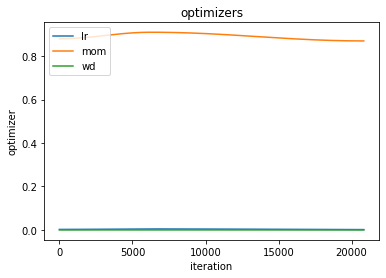

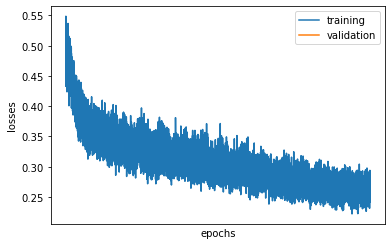

(None, None)

In [ ]:
import matplotlib.pyplot as plt

learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=15),plt.show()

In [ ]:
%%time

stocks = test_ds.stocks[:] #"AAPL"
price_targets, prediction_columns = predict_stocks(test_ds, mm, stocks, tensor_input_view )
price_targets.head()

In [ ]:
#statistics on the columns and their predicted values
columns = test_ds.column_names.copy()
columns.extend(prediction_columns)
print(columns)
price_targets.loc[:,columns].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])        


In [ ]:
#plot signal vs prediction
#AAPL
stock             = stocks[0]
df                = price_targets.loc[stock].iloc[128:256] # extract a section
training_column   = training_column_names[0]
prediction_column = prediction_columns[0]

reference_values  = df[training_column].to_numpy()
prediction_values = df[prediction_column].to_numpy()
dates             = np.arange(len(reference_values))
same_sign         = np.sign(reference_values) == np.sign(prediction_values)

reference_same_sign  = (reference_values[same_sign],  stock+" reference", "blue",  "line")
prediction_same_sign = (prediction_values[same_sign], stock+" prediction","green","circle")
#prediction_opposite_sign = (prediction_values[np.logical_not(same_sign)], stock+" prediction","red","circle")

plotSignalVSPrediction(dates[same_sign],[reference_same_sign,prediction_same_sign])

In [ ]:
df[training_column_names].to_numpy()[:,0].shape

In [ ]:
price_targets.iloc[:10,-5:]

In [ ]:
from math import sqrt
normalization_faktor=2.7e-02
print(sqrt(0.000250), 0.01**2) #0.000295
print(sqrt(0.758663)*normalization_faktor, 0.01**2)


In [ ]:
#mm.model[0][0].weight
#mm.model[0][0].bias

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()